# Docking Control Design

In [1]:
import casadi as ca
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

In [2]:
def derive_eqs():
    r_c = ca.SX.sym('r_c', 3)
    v_c = ca.SX.sym('v_c', 3)
    r_t = ca.SX.sym('r_t', 3)
    v_t = ca.SX.sym('v_t', 3)
    r_e = ca.SX.zeros(3)
    
    m_t = ca.SX.sym('m_t')
    m_c = ca.SX.sym('m_c')
    m_e = ca.SX.sym('m_e')
    
    omega = ca.SX.sym('omega')
    r0 = ca.SX.sym('r0')
    
    r_0 = ca.vertcat(r0, 0, 0)
    r_c0 = r_c + r_0
    r_t0 = r_t + r_0

    omg_vec = ca.vertcat(0, 0, omega)

    G = ca.SX.sym('G')
    F_thrust = ca.SX.sym('F_thrust', 3)

    def force_gravity(m1, r1, m2, r2):
        r = ca.norm_2(r2 - r1)
        return ca.if_else(r < 1e-2, ca.SX.zeros(3), G*m1*m2*(r2 - r1)/r**3)

    F_c = force_gravity(m_c, r_c0, m_t, r_t0) + force_gravity(m_c, r_c0, m_e, r_e) + F_thrust
    F_t = force_gravity(m_t, r_t0, m_c, r_c0) + force_gravity(m_t, r_t0, m_e, r_e)

    # state
    x = ca.vertcat(r_c, v_c, r_t, v_t)

    # dynamics
    x_dot = ca.vertcat(
        v_c,
        F_c/m_c - 2*ca.cross(omg_vec, v_c) - ca.cross(omg_vec, ca.cross(omg_vec, r_c0)),
        v_t,
        F_t/m_t - 2*ca.cross(omg_vec, v_t) - ca.cross(omg_vec, ca.cross(omg_vec, r_t0))
    )
                                        

    # input
    u = ca.vertcat(F_thrust)
    
    # output
    y = ca.vertcat(r_c - r_t, v_c - v_t)

    # parameters
    p = ca.vertcat(m_c, m_t, m_e, G, r0, omega)

    def saturate(f, norm_max):
        n = ca.norm_2(f)
        return ca.if_else(n > norm_max, f*norm_max/n, f)
    
    # controller
    pd_control = saturate(1*(r_t - r_c) + 200*(v_t - v_c), 1) # simple PD control
    
    rhs = ca.Function('rhs', [x, u, p], [x_dot])
    measure = ca.Function('measure', [x, u, p], [y])
    control = ca.Function('control', [x, p], [pd_control])
    
    x_name = ['px_c', 'py_c', 'pz_c', 'vx_c', 'vy_c', 'vz_c', 'px_t', 'py_t', 'pz_t', 'vx_t', 'vy_t', 'vz_t']
    x_id = {name: i for i, name in enumerate(x_name)}
    
    y_name = ['px_e', 'py_e', 'pz_e', 'vx_e', 'vy_e', 'vz_e']
    y_id = {name: i for i, name in enumerate(y_name)}

    u_name = ['fx', 'fy', 'fz']
    u_id = {name: i for i, name in enumerate(u_name)}
    
    p_name = ['m_c', 'm_t', 'm_e', 'G', 'r0', 'omega']
    p_id = {name: i for i, name in enumerate(p_name)}

    return locals()

eqs = derive_eqs()

In [3]:
def simulate(eqs):
    r_geo = 42164e3
    G = 6.67408e-11
    m_e = 5.972e24
    m_t = 419709 # iss mass
    m_c = 1000
    v_geo = np.sqrt(G*m_e/r_geo)
    omega = v_geo/r_geo

    p0 = [m_c, m_t, m_e, G, r_geo, omega]
    u0 = [0, 0, 0]
    
    # initial state: chaser: x, y, z, vx, vy, vz, target: x, y, z, vx, vy, vz
    x0 = [-1000, -1000, 1000, 1, 0.1, 0.2, 0, 0, 0, 0.1, 0.1, 0.1]
    dt = 60
    tf = 4*3600 # 4 hours
    
    t_vect = np.arange(0, tf, dt)
    
    data = {
        't': [],
        'x': [],
        'u': [],
        'y': []
    }
    xi = x0
    for ti in t_vect:
        data['t'].append(ti)
        ui = np.array(eqs['control'](xi, p0)).reshape(-1)
        data['u'].append(ui)
        res = scipy.integrate.solve_ivp(lambda t, x:np.array(eqs['rhs'](x, ui, p0)).reshape(-1), t_span=[ti, ti + dt], y0=xi, method='LSODA')
        xi = np.array(res['y'][:, -1]).reshape(-1)
        data['x'].append(xi)
        yi = np.array(eqs['measure'](xi, u0, p0)).reshape(-1)
        data['y'].append(yi)

    for k in data.keys():
        data[k] = np.array(data[k])
    return data

data = simulate(eqs)

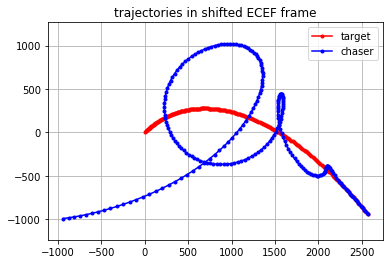

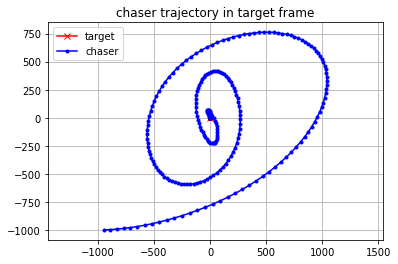

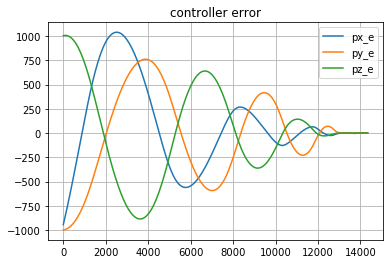

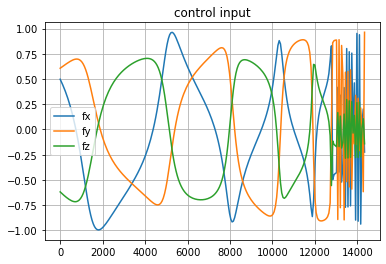

In [4]:
plt.figure()
plt.title('trajectories in shifted ECEF frame')
plt.plot(data['x'][:, eqs['x_id']['px_t']], data['x'][:, eqs['x_id']['py_t']], 'r.-', label='target')
plt.plot(data['x'][:, eqs['x_id']['px_c']], data['x'][:, eqs['x_id']['py_c']], 'b.-', label='chaser')
plt.legend()
plt.grid()
plt.axis('equal');

plt.figure()
plt.title('chaser trajectory in target frame')
plt.plot(0, 0, 'rx-', label='target')
plt.plot(data['y'][:, eqs['y_id']['px_e']], data['y'][:, eqs['y_id']['py_e']], 'b.-', label='chaser')
plt.legend()
plt.grid()
plt.axis('equal');

plt.figure()
plt.title('controller error')
plt.plot(data['t'], data['y'][:, eqs['y_id']['px_e']], label='px_e')
plt.plot(data['t'], data['y'][:, eqs['y_id']['py_e']], label='py_e')
plt.plot(data['t'], data['y'][:, eqs['y_id']['pz_e']], label='pz_e')
plt.legend()
plt.grid()

plt.figure()
plt.title('control input')
plt.plot(data['t'], data['u'][:, eqs['u_id']['fx']], label='fx')
plt.plot(data['t'], data['u'][:, eqs['u_id']['fy']], label='fy')
plt.plot(data['t'], data['u'][:, eqs['u_id']['fz']], label='fz')

plt.legend()
plt.grid()